In [3]:
import pyspark 
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
from pyspark.sql.functions import col, count
import pyspark.sql.functions as f
from pyspark.sql import SQLContext

In [4]:
### read in WA state school enrollment file
df = spark.read.format("csv").option("inferSchema",True).option("header",True).load("Report_Card_Enrollment_from_2014-15_to_Current_Year.csv")

#look at name and data types for each column
df.printSchema()

root
 |-- SchoolYear: string (nullable = true)
 |-- OrganizationLevel: string (nullable = true)
 |-- County: string (nullable = true)
 |-- ESDName: string (nullable = true)
 |-- ESDOrganizationID: integer (nullable = true)
 |-- DistrictCode: integer (nullable = true)
 |-- DistrictName: string (nullable = true)
 |-- DistrictOrganizationId: integer (nullable = true)
 |-- SchoolCode: integer (nullable = true)
 |-- SchoolName: string (nullable = true)
 |-- SchoolOrganizationid: integer (nullable = true)
 |-- CurrentSchoolType: string (nullable = true)
 |-- Gradelevel: string (nullable = true)
 |-- All Students: integer (nullable = true)
 |-- Female: integer (nullable = true)
 |-- Male: integer (nullable = true)
 |-- Gender X: integer (nullable = true)
 |-- American Indian/ Alaskan Native: integer (nullable = true)
 |-- Asian: integer (nullable = true)
 |-- Black/ African American: integer (nullable = true)
 |-- Hispanic/ Latino of any race(s): integer (nullable = true)
 |-- Native Hawaiian

In [7]:
#look at sample rows of data
df.limit(3).show(truncate=True)

+----------+-----------------+--------+-----------+-----------------+------------+------------+----------------------+----------+-----------+--------------------+-----------------+----------+------------+------+-----+--------+-------------------------------+-----+-----------------------+-------------------------------+---------------------------------------+-----------------+-----+-------------------------+-----------+--------+----------+-------+---------------+------+-----------+--------------------------+-----------------------------+---------------+------------+--------------+-----------+-------------------+----------+---------------+-----------------------------+--------------------+
|SchoolYear|OrganizationLevel|  County|    ESDName|ESDOrganizationID|DistrictCode|DistrictName|DistrictOrganizationId|SchoolCode| SchoolName|SchoolOrganizationid|CurrentSchoolType|Gradelevel|All Students|Female| Male|Gender X|American Indian/ Alaskan Native|Asian|Black/ African American|Hispanic/ Latin

In [8]:
# get unique column values
df.select("OrganizationLevel").distinct().show()

+-----------------+
|OrganizationLevel|
+-----------------+
|           School|
|            State|
|         District|
+-----------------+



In [9]:
# get unique column values
df.select("Gradelevel").distinct().show()

+--------------------+
|          Gradelevel|
+--------------------+
|           7th Grade|
|           6th Grade|
|           3rd Grade|
|           2nd Grade|
|          12th Grade|
|           1st Grade|
|           5th Grade|
|          11th Grade|
|           9th Grade|
|Half-day Kinderga...|
|          10th Grade|
|           8th Grade|
|    Pre-Kindergarten|
|           AllGrades|
|        Kindergarten|
|           4th Grade|
+--------------------+



In [10]:
# get unique column values
df.select("SchoolYear").distinct().show()

+----------+
|SchoolYear|
+----------+
|   2016-17|
|   2015-16|
|   2014-15|
|   2018-19|
|   2019-20|
|   2017-18|
+----------+



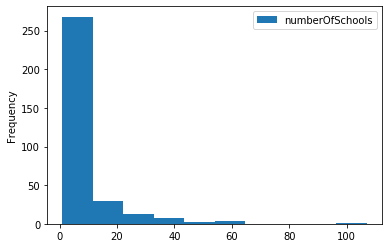

In [12]:
#get number of schools in each school district
numSchool = df.filter((df.SchoolYear=='2018-19') & \
                      (df.Gradelevel=='AllGrades') & \
                      (df.OrganizationLevel=='School')).\
             groupBy(col("DistrictName")).count().\
             select("DistrictName",col('count').alias("numberOfSchools")) 

numSchool.toPandas().plot(kind='hist')

In [13]:
#get a list of school districts with higher number of schools
numSchool.sort('numberOfSchools',ascending=False).show()

+--------------------+---------------+
|        DistrictName|numberOfSchools|
+--------------------+---------------+
|Seattle School Di...|            107|
|Tacoma School Dis...|             62|
|Spokane School Di...|             61|
|Lake Washington S...|             55|
|Federal Way Schoo...|             46|
|Kent School District|             44|
|Vancouver School ...|             40|
|Edmonds School Di...|             38|
|Evergreen School ...|             37|
|Puyallup School D...|             36|
|Northshore School...|             36|
|Highline School D...|             34|
|Clover Park Schoo...|             33|
|Bellevue School D...|             31|
|Kennewick School ...|             31|
|Bethel School Dis...|             31|
|Everett School Di...|             30|
|Central Valley Sc...|             29|
|Renton School Dis...|             29|
|Issaquah School D...|             27|
+--------------------+---------------+
only showing top 20 rows



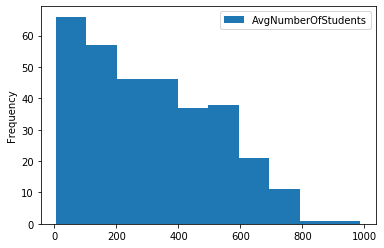

In [14]:
#get average number of students per school for each school district
numStudents = df.filter((df.SchoolYear=='2018-19') & \
                      (df.Gradelevel=='AllGrades') & \
                      (df.OrganizationLevel=='School')).\
             groupBy(col("DistrictName")).avg('All Students').alias("Average Number of Students").\
             toDF('DistritName','AvgNumberOfStudents')#.

numStudents.toPandas().plot(kind='hist')

In [15]:
#get a list of school district with larger avg. student body
numStudents.sort('AvgNumberOfStudents',ascending=False).show()

+--------------------+-------------------+
|         DistritName|AvgNumberOfStudents|
+--------------------+-------------------+
|Tahoma School Dis...|  987.2222222222222|
|Mary M Knight Sch...|              836.5|
|Pasco School Dist...|  782.2083333333334|
|Issaquah School D...|  776.2962962962963|
|Sunnyside School ...|  761.6666666666666|
|Mercer Island Sch...|  753.6666666666666|
|Auburn School Dis...|  733.7916666666666|
|University Place ...|            728.375|
|Lake Stevens Scho...|              715.0|
|Richland School D...|             709.95|
|Bellevue School D...|  701.4516129032259|
|Everett School Di...|  698.3333333333334|
|Mukilteo School D...|  696.1304347826087|
|North Thurston Pu...|  691.9090909090909|
|Evergreen School ...|  680.5675675675676|
|Sumner School Dis...|  673.3333333333334|
|Hockinson School ...|  663.6666666666666|
|Northshore School...|  654.0833333333334|
|Bethel School Dis...|  652.3870967741935|
|Griffin School Di...|              652.0|
+----------

In [16]:
#########first part: Seattle School District ##############################
df.registerTempTable('df_table')

# select only Seattle school district data (DistrictCode 17001)
seattle_enrolment_table = spark.sql( "SELECT * FROM df_table WHERE DistrictCode == 17001" )
seattle_enrolment_table.toPandas().to_csv('seattle_enrolment.csv',index=False)

In [ ]:
### process the rest of the data (assessment, discipline, graduation, classsize, teacher, etc.)
dataDict = {'assessment':"Report_Card_Assessment_Data_from_2014-15_to_Current_Year.csv",
            'discipline':'Report_Card_Discipline_for_2014-15_to_Current_Year.csv',
            'graduation': 'Report_Card_Graduation_2014-15_to_Most_Recent_Year.csv',
            'growth':'Report_Card_Growth_from_2014-15_to_Current_Year.csv',
            'sqss':'Report_Card_SQSS_from_2014-15_to_Current_Year.csv',
            'classsize':'E9_Avg_Class_Size.csv', 'teacherqual':'E11_Teacher_Qualifications.csv',
            'teacherexp':'E4_Summary_Years_Exp.csv'}

for aspect in dataDict.keys():
    inFileName = dataDict[aspect]
    df = spark.read.format("csv").option("inferSchema",True).option("header",True).load(inFileName)
    outFileName = 'seattle_'+aspect+'.csv'
    df.filter(col("DistrictCode")==17001).toPandas().to_csv(outFileName,index=False)
